# Compute Generalized Additive Models for the Grid

This notebooks computes the Generalized Additive Models (GAM) that fit to the Temperature12K data.

In [1]:
import pandas as pd
import numpy as np
import os.path as osp
import os
from urllib import request
import zipfile
import pickle
from openpyxl import load_workbook
import matplotlib.pyplot as plt
from pygam import LinearGAM
import pygam
import xarray as xr
import multiprocessing as mp
import psyplot.data as psyd
import gam_ensemble as ge
import pyleogrid as pg
from distributed import Client
import psyplot.project as psy
from matplotlib.animation import FuncAnimation
import contextlib
from sklearn.neighbors import BallTree
from latlon_utils import get_climate
import lipd

<a id=db_version></a>Read in the LipD data from http://lipdverse.org/globalHolocene/current_version

You should set the latest version here manually!

In [2]:
%matplotlib inline

In [3]:
db_version = '0_43_0'

In [4]:
%%time
if not osp.exists('../data'):
    os.makedirs('../data')
    zipped = f'globalHolocene{db_version}.zip'
    uri = f'http://lipdverse.org/globalHolocene/{db_version}/{zipped}'
    target = osp.join('../data', zipped)
    print('downloading ' + uri)
    request.urlretrieve(uri, target)
    with zipfile.ZipFile(target) as f:
        f.extractall('../data')

CPU times: user 76 µs, sys: 80 µs, total: 156 µs
Wall time: 98.9 µs


In [5]:
@contextlib.contextmanager
def remember_cwd():
    """Context manager to switch back to the current working directory

    Usage::

        with remember_cwd():
            os.chdir('test')
            print(os.getcwd())  # test
        print(os.getcwd())      # test/.."""
    curdir = os.getcwd()
    try:
        yield
    except:
        raise
    finally:
        os.chdir(curdir)

In [6]:
%%time
pickle_file = '../data/lipds.pkl'
if osp.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
else:
    with remember_cwd():
        os.chdir('../data/')
        data = lipd.readLipd('.')
    with open(pickle_file, 'wb') as f:
        pickle.dump(data, f)

CPU times: user 388 ms, sys: 76.1 ms, total: 464 ms
Wall time: 517 ms


In [7]:
%%time
all_series = lipd.extractTs(data)

extracting paleoData...
extracting: SaintViaudContin.EPD
extracting: Hams.Bennett.1987
extracting: MV99-GC31.Barron.2012
extracting: MD07_3128
extracting: EagleTarn.Rees.2010
extracting: MD84_551
extracting: Sonk11D.Lauterbach.2014
extracting: HjortSo.Wagner.2008
extracting: Alley.GISP2.2000
extracting: SudobleLake.EPD
extracting: Victoria.Berke.2012
extracting: HU72_021_3
extracting: SaladaPequena.EPD
extracting: GeoB58044.Lamy.2003
extracting: Frozen.Rosenberg.2004
extracting: GeoB9307_3
extracting: GeoB3359_3
extracting: Composit_MD012421,KR0206
extracting: FloatingIsland.Baker.1976
extracting: BebrukasLake.EPD
extracting: MoorAlpenrose.EPD
extracting: LakeSix.Liu.1990
extracting: ScreamingLynxLake.Clegg.2011
extracting: GodziszewskieLake.EPD
extracting: LonarLake.Prasad.2014
extracting: Malawi.Johnson.2016
extracting: LakeStowell.Lemmen.2018
extracting: WCA3B_GumboLimboFarTail.Willard.2001
extracting: ME0005A_24JC
extracting: Haengstli.EPD
extracting: Coghill.King.1986
extracting: 

extracting: MSM5_512
extracting: LakeLednica-1.EPD
extracting: JamesRossIsland.Mulvaney.2012
extracting: LakeNalengcuo.Pollen.China
extracting: Big.Cumming.2002
extracting: ODP1019.Barron.2003
extracting: ColdWater.Denniston.1999
extracting: KNR159_5_36GGC
extracting: MD952042.Bard.2002
extracting: JM98-1.Husum.2004
extracting: Hams.Shuman.2016
extracting: Logan.Fisher.2008
extracting: VM12_107
extracting: WiggenhallSt.Germans.EPD
extracting: GeoB9508_5
extracting: LaBeuffarde.EPD
extracting: LeFourneau.EPD
extracting: OwensLake.Benson.2002
extracting: B997_324
extracting: LakeSkrzetuszewskie.EPD
extracting: VestreOykjamyrtorn.EPD
extracting: Emerald.Shuman.2014
extracting: Masoko.Garcin.2006
extracting: PortageBog.Anderson.1980
extracting: vuoskkujavri.Bigler.2002
extracting: PorquiPond.McAndrews.NA
extracting: dalmutladdo.Bjune.2004
extracting: PSh-5157.Risebrobakken.2011
extracting: Buckeye.Springer.2008
extracting: MD84_527.Assemblage
extracting: CC04
extracting: KZAI_01
extracting

extracting: FinseStasjonsdam.Velle.2005
extracting: ODP_176_1014
extracting: M135_005_3
extracting: U938
extracting: Devils.Maher.1982
extracting: Gradenmoos.EPD
extracting: Kharinei.Pollen.Russia
extracting: 893A.Kennet.2007
extracting: LeadingTickles.Macpherson.1985
extracting: SouthernCalifornia.OhlweinWahl.2012
extracting: DA05.Lloyd.2007
extracting: SO201_2_12
extracting: MD02_2489
extracting: Hurleg.Zhao.2013
extracting: QunfCave.Fleitmann.2007
extracting: OCE326_GGC26
extracting: NAP_63_1
extracting: starvatn.Andresen.2006
extracting: MD98_2181
extracting: Aus-MarxUpperSnowy
extracting: MD98_2195
extracting: V2130
extracting: GeoB10069-3.Gibbons.2014
extracting: Etangd'Ouveillan.EPD
extracting: FoyLake.Stone.2008
extracting: PS2138_1
extracting: Crates.Liu.NA
extracting: ParkPond1.Lynch.1998
extracting: MaraisdeCharauze.EPD
extracting: PeatlandKlukva.Pollen.Russia
extracting: Laihalampi.Giesecke.2008
extracting: CN01.Cheung.2017
extracting: Compass.Macpherson.1986
extracting: Ja

extracting: LakeKupal'noe.Ilyashuk.2013
extracting: MSM05-723..2012
extracting: Pingwang.Pollen.China
extracting: Moanatuatua.Jara.2017
extracting: SO139-74KL.Luckge.2008
extracting: LakeVan.Chen.2008
extracting: Vostok.Vimeux.2002
extracting: 165_1002C
extracting: CH0798GGC19
extracting: Alsa.EPD
extracting: MD02-2515.Bhattacharya.2018
extracting: LowerBearLake.Kirby.2012
extracting: BeaverLake.Schmieder.2011
extracting: MD03_2607.Assemblage
extracting: EnosLake.Brown.2006
extracting: Hinterburgsee.Heiri.2015
extracting: Mendota.Winkler.1986
extracting: Moon.Grimm.1996
extracting: LakeVan.EPD
extracting: Tigalmamine.Climate-12k-Site-Data-Entry-Form-v3.Tigalmamine
extracting: CristolLake.EPD
extracting: gloppsjon.Seppa.2009
extracting: GeoB7622-2.Lamy.2006
extracting: MD982176
extracting: Ghirla.Wirth.2016
extracting: LacLouis.Vincent.1973
extracting: LakeRacze.EPD
extracting: Menez-Cam.EPD
extracting: Grenadier.McAndrews.1988
extracting: NewLong.Newby.2014
extracting: LimeLake.Steinma

extracting: brurskardstjorni.Velle.2005
extracting: Kansjon.EPD
extracting: haugtjern.Eide.2009
extracting: ODP_175_1084B
extracting: Nesmeyanov_GGC_15
extracting: PL07_39PC
extracting: PolandSpring.Jacobson.Ja
extracting: Wachel3.EPD
extracting: KP2.Seppa.2009
extracting: Myrtle.Janssen.1968
extracting: PAR87A_10
extracting: Jellybean.Anderson.2005
extracting: meleze.MacDonald.1983
extracting: WAISBubble.Fegyveresi.2016
extracting: BaiedeSeineestuary.EPD
extracting: JPC67.Bertrand.2017
extracting: SL06.Pollen.Canada
extracting: SK237-GC04.Saraswat.2013
extracting: AD9117.Guinta.2001
extracting: Delorme2.Bouchard.1982
extracting: PusciznaRekowianska.EPD
extracting: MD01_2461
extracting: Donvold.EPD
extracting: LagunaDeJuanacatlan.Jones.2015
extracting: Woryty.EPD
extracting: SacredLake
extracting: Caribou.Labelle.1992
extracting: DovjokSwamp.EPD
extracting: Kilimanjaro.Thompson.2002
extracting: Medvedevskoe.Nazarova.2018
extracting: Kamenicky.EPD
extracting: Core17940
extracting: Mjauv

extracting: BlackSea(Southwest2).EPD
extracting: MD95_2039
extracting: SO201_2_101
extracting: PetenItza.Curtis.1998
extracting: Dolgoe.Wolfe.2000
extracting: DevilsLake.Shuman.2016
extracting: GeoB9528-3.Collins.2013
extracting: MD95_2011
extracting: GeoB12615_4
extracting: LagunaChaplin.Pollen.Bolivia
extracting: M77_2_056_5
Created time series: 9273 entries
CPU times: user 10 s, sys: 2.15 s, total: 12.2 s
Wall time: 12.1 s


In [8]:
all_chrons = lipd.extractTs(data, 'all', mode='chron')

extracting chronData...
extracting: SaintViaudContin.EPD
extracting: Hams.Bennett.1987
extracting: MV99-GC31.Barron.2012
extracting: MD07_3128
extracting: EagleTarn.Rees.2010
extracting: MD84_551
extracting: Sonk11D.Lauterbach.2014
extracting: HjortSo.Wagner.2008
extracting: Alley.GISP2.2000
extracting: SudobleLake.EPD
extracting: Victoria.Berke.2012
extracting: HU72_021_3
extracting: SaladaPequena.EPD
extracting: GeoB58044.Lamy.2003
extracting: Frozen.Rosenberg.2004
extracting: GeoB9307_3
extracting: GeoB3359_3
extracting: Composit_MD012421,KR0206
extracting: FloatingIsland.Baker.1976
extracting: BebrukasLake.EPD
extracting: MoorAlpenrose.EPD
extracting: LakeSix.Liu.1990
extracting: ScreamingLynxLake.Clegg.2011
extracting: GodziszewskieLake.EPD
extracting: LonarLake.Prasad.2014
extracting: Malawi.Johnson.2016
extracting: LakeStowell.Lemmen.2018
extracting: WCA3B_GumboLimboFarTail.Willard.2001
extracting: ME0005A_24JC
extracting: Haengstli.EPD
extracting: Coghill.King.1986
extracting: 

extracting: BanksIsland74MS11.Gajewski.2000
extracting: A7
extracting: GraechenSee.EPD
extracting: RedmountainLake.Chase.2008
extracting: MD99_2269
extracting: BearBog.McAndrews.1992
extracting: LakeDuranunlak.EPD
extracting: Midden.Cluster3.2019
extracting: Midden.Cluster2.2019
extracting: M40-4-SL78.Emeis.2003
extracting: braya_so.Dandrea.2011
extracting: Ammersee.Czymzik.2012
extracting: MSM5_512
extracting: LakeLednica-1.EPD
extracting: JamesRossIsland.Mulvaney.2012
extracting: LakeNalengcuo.Pollen.China
extracting: Big.Cumming.2002
extracting: ODP1019.Barron.2003
extracting: ColdWater.Denniston.1999
extracting: KNR159_5_36GGC
extracting: MD952042.Bard.2002
extracting: JM98-1.Husum.2004
extracting: Hams.Shuman.2016
extracting: Logan.Fisher.2008
extracting: VM12_107
extracting: WiggenhallSt.Germans.EPD
extracting: GeoB9508_5
extracting: LaBeuffarde.EPD
extracting: LeFourneau.EPD
extracting: OwensLake.Benson.2002
extracting: B997_324
extracting: LakeSkrzetuszewskie.EPD
extracting: Ve

extracting: Rystad.Vorren.2012
extracting: GeoB100384.Mohtadi.2010
extracting: RainbowLake.Shuman.2016
extracting: XingyunLake.Wu.2018
extracting: JPC76.Friddell.2002
extracting: MD022529.Leduc.2007
extracting: GYXO.Self.2015
extracting: Porphyry.Brown.2002
extracting: SanJuanRiverDischarge.Brown.2015
extracting: Zalozhtsy.EPD
extracting: TigrePerdido.vanBreukelen.2008
extracting: hudson.Clegg.2011
extracting: Mount_Honey
extracting: tibetanus.Hammarlund.2002
extracting: SO90_63KA
extracting: FinseStasjonsdam.Velle.2005
extracting: ODP_176_1014
extracting: M135_005_3
extracting: U938
extracting: Devils.Maher.1982
extracting: Gradenmoos.EPD
extracting: Kharinei.Pollen.Russia
extracting: 893A.Kennet.2007
extracting: LeadingTickles.Macpherson.1985
extracting: SouthernCalifornia.OhlweinWahl.2012
extracting: DA05.Lloyd.2007
extracting: SO201_2_12
extracting: MD02_2489
extracting: Hurleg.Zhao.2013
extracting: QunfCave.Fleitmann.2007
extracting: OCE326_GGC26
extracting: NAP_63_1
extracting: s

extracting: DevonIslandGlacier.McAndrews.1984
extracting: SaintGabriel.Larouche.1977
extracting: Edward.Russell.2003
extracting: AdelaideTarn.Jara.2015
extracting: Cadagno.Wirth.2013
extracting: NP04KH3KH4.Tierney.2008
extracting: Hudson.Bailey.1972
extracting: LagoMoreno.Pollen.Argentina
extracting: LostLake_MT.Whitlock.1989
extracting: GIK12328_5
extracting: PS2208_1
extracting: ODP1019D
extracting: LittleBass.Swain.NA
extracting: arapisto.Sarmaja-Korjonen.2007
extracting: DonggeCave.Dyoski.2005
extracting: Amtkel1.EPD
extracting: Hypkana.Hajkova.2016
extracting: LakeKupal'noe.Ilyashuk.2013
extracting: MSM05-723..2012
extracting: Pingwang.Pollen.China
extracting: Moanatuatua.Jara.2017
extracting: SO139-74KL.Luckge.2008
extracting: LakeVan.Chen.2008
extracting: Vostok.Vimeux.2002
extracting: 165_1002C
extracting: CH0798GGC19
extracting: Alsa.EPD
extracting: MD02-2515.Bhattacharya.2018
extracting: LowerBearLake.Kirby.2012
extracting: BeaverLake.Schmieder.2011
extracting: MD03_2607.Asse

extracting: Schwarzsee.EPD
extracting: Colo.Baker.1990
extracting: EW0408_85JC
extracting: LacMarcotte.Labelle.1981
extracting: OCE326_GGC5
extracting: SS8.Anderson.2012
extracting: ODP_202_1233
extracting: Furnival.McAndrews.NA
extracting: NIOP905_UK37
extracting: PS1927_2
extracting: SecretLake.Lasher.2017
extracting: Minakokosa.Anderson.NA
extracting: HU73_011_31
extracting: PC01
extracting: GeoB9310_4
extracting: Mawmluh.Berkelhammer.2012
extracting: BeefPasture.Petersen.1985
extracting: brurskardstjorni.Velle.2005
extracting: Kansjon.EPD
extracting: haugtjern.Eide.2009
extracting: ODP_175_1084B
extracting: Nesmeyanov_GGC_15
extracting: PL07_39PC
extracting: PolandSpring.Jacobson.Ja
extracting: Wachel3.EPD
extracting: KP2.Seppa.2009
extracting: Myrtle.Janssen.1968
extracting: PAR87A_10
extracting: Jellybean.Anderson.2005
extracting: meleze.MacDonald.1983
extracting: WAISBubble.Fegyveresi.2016
extracting: BaiedeSeineestuary.EPD
extracting: JPC67.Bertrand.2017
extracting: SL06.Pollen

extracting: naujg1.Willemse.1999
extracting: MD972141
extracting: WAISDivide.Cuffey.2016
extracting: north.Axford.2013
extracting: LacHamard.Stravers.1981
extracting: GeoB7165_1
extracting: HLY02_02_51JPC
extracting: Axe.McAndrews.No
extracting: ThorpeBulmer.EPD
extracting: EagleLake.Rosenberg.2004
extracting: BoundaryPond.Mott.1977
extracting: GeoB1711_4
extracting: LifebuoyLake.Solivieva.2015
extracting: Rapid.Fall.1994
extracting: PogoniaBog.Cushing.1979
extracting: KNR166_14_11JPC
extracting: IOW225514
extracting: MV0811-14JC.Du.2018
extracting: MD02_2594
extracting: BlackSea(Southwest2).EPD
extracting: MD95_2039
extracting: SO201_2_101
extracting: PetenItza.Curtis.1998
extracting: Dolgoe.Wolfe.2000
extracting: DevilsLake.Shuman.2016
extracting: GeoB9528-3.Collins.2013
extracting: MD95_2011
extracting: GeoB12615_4
extracting: LagunaChaplin.Pollen.Bolivia
extracting: M77_2_056_5
Created time series: 9707 entries


In [9]:
def is_numeric(val):
    return np.can_cast(np.asarray(val), float)

from collections import Counter
counter = Counter([d['chronData_variableName'] for d in all_chrons])
counter_df = pd.DataFrame.from_dict({key: [val] for key, val in counter.items()}, orient='index')
counter_df.columns = ['Number of occurences']
counter_df.index.name = 'chronData_variableName'

mins = []
maxs = []
lengths = []

for variable in counter_df.index:
    series = [d for d in all_chrons if 
              d['chronData_variableName'] == variable and 
             'chronData_values' in d and
             is_numeric(d['chronData_values'])]
    if series:
        mins.append(np.nanmin([np.nanmin(d['chronData_values']) for d in series]))
        maxs.append(np.nanmax([np.nanmax(d['chronData_values']) for d in series]))
        lengths.append(np.mean(list(map(len, [d['chronData_values'] for d in series]))))
    else:
        mins.append(np.nan)
        maxs.append(np.nan)
        lengths.append(np.nan)
counter_df['min'] = mins
counter_df['max'] = maxs
counter_df['average length'] = lengths

In [10]:
filtered_ts_temp12k = lipd.filterTs(all_series,'paleoData_inCompilation == Temp12k')
temperatures = lipd.filterTs(filtered_ts_temp12k,'paleoData_units == degC')
sorted(temperatures[0])

Found 1328 matches from 9273 columns
Found 1285 matches from 1328 columns


['@context',
 'age',
 'ageUnits',
 'agesPerKyr',
 'archiveType',
 'createdBy',
 'dataContributor',
 'dataSetName',
 'depth',
 'depthUnits',
 'geo_country',
 'geo_countryOcean',
 'geo_meanElev',
 'geo_meanLat',
 'geo_meanLon',
 'geo_siteName',
 'lipdVersion',
 'lipdverseLink',
 'maxYear',
 'minYear',
 'mode',
 'nUniqueAges',
 'nUniqueOtherAges',
 'neotomaDatasetId',
 'originalDataUrl',
 'otherAgesPerKyr',
 'paleoData_QCCertification',
 'paleoData_TSid',
 'paleoData_calibration_method',
 'paleoData_datum',
 'paleoData_filename',
 'paleoData_hasMaxValue',
 'paleoData_hasMeanValue',
 'paleoData_hasMedianValue',
 'paleoData_hasMinValue',
 'paleoData_hasResolution_hasMaxValue',
 'paleoData_hasResolution_hasMeanValue',
 'paleoData_hasResolution_hasMedianValue',
 'paleoData_hasResolution_hasMinValue',
 'paleoData_inCompilation',
 'paleoData_interpretation',
 'paleoData_meanValue12k',
 'paleoData_medianRes12k',
 'paleoData_missingValue',
 'paleoData_number',
 'paleoData_proxy',
 'paleoData_prox

In [124]:
from collections import defaultdict, Counter
from itertools import chain
names = {key: [] for key in set(chain.from_iterable(d['paleoData_interpretation'][0] for d in temperatures))}
for d in temperatures:
    for key in names:
        names[key].append(
            d['paleoData_interpretation'][0].get(key))
        
counts = {key: Counter(val) for key, val in names.items()}
pd.DataFrame.from_dict(counts['variableDetail'], orient='index')

,0
air@surface,905
lake@surface,6
sea@surface,228
NaN,136
water@surface,4
sea@thermocline,1
sea@subsurface,3
LST+air,1
air@suface,1


In [11]:
set(d.get('paleoData_proxy') for d in temperatures)

{'3-OH-Fatty Acids',
 'C15 fatty alcohols',
 'GDGT',
 'LDI',
 'Mg/Ca',
 'TEX86',
 'TRW',
 'alkenone',
 'borehole',
 'bubble frequency',
 'chironomid',
 'chlorophyll',
 'd13C',
 'd18O',
 'dD',
 'deterium excess',
 'diatom',
 'dinocyst',
 'foraminifera',
 'gas',
 'hybrid-ice',
 'isotope diffusion',
 'long chain diol',
 'macrofossils',
 'melt layer',
 'pollen'}

In [12]:
meta_cols = ['geo_meanLon', 'geo_meanLat', 'dataSetName', 'paleoData_variableName', 'paleoData_TSid', 
             'paleoData_interpretation.0.seasonalityGeneral', 'paleoData_datum', 'paleoData_proxy']
meta_names = ['lon', 'lat', 'dataSetName', 'variableName', 'TSid', 'seasonality', 'datum', 'proxy']

In [13]:
frames = []
failures = []
for d in temperatures:
    if 'age' in d:
        try:
            s = pd.Series(
                np.asarray(d['paleoData_values'], dtype=float),
                index=pd.Index(np.asarray(d['age'], dtype=float), name='age'),
                name='temperature')
        except ValueError:
            failures.append(d)
        else:
            frame = s.to_frame().reset_index()
            for i, name in enumerate(meta_cols):
                sub = d
                vals = name.split('.')
                name = vals[-1]
                for v in vals[:-1]:
                    sub = sub[v if isinstance(sub, dict) else int(v)]
                frame[meta_names[i]] = sub.get(name, np.nan)
            frames.append(frame)

In [14]:
d = failures[0]
np.asarray(d['paleoData_values'])

array(['0-1.1', 'nan', '10.6-11.6', 'nan', 'nan', 'nan', '21.1-22.2',
       'nan', '31.7-32.8', 'nan', '42.3-43.3', 'nan', '52.9-53.9',
       '63.4-64.5', 'nan', '75.5-77.0', 'nan', '85.4-86.5', 'nan',
       '101.4-102.5', 'nan',
       '103.7-104.8 U. Tasmania  103.7-104.8 UC Davis', 'nan',
       '105.9-107.0 UC Davis  105.9-107.0 U. Tasmania',
       '107.0-108.1 U. Tasmania', '108.1-109.2 UC Davis', '110.3-111.4',
       '112.5-113.6', 'nan', 'nan', '2.2635', 'nan',
       '121.4-122.5 UC Davis', '123.6-124.7', '125.6-126.9 UC Davis',
       '128.0-129.2 UC Davis', '0.6035', '130.3-131.4 UC Davis',
       '132.5-133.6 UC Davis', '134.7-135.8', '136.9-138.0 UC Davis',
       '139.1-140.2 UC Davis', '-1.3365', '141.3-142.5 UC Davis', 'nan',
       '145.8-146.9 UC Davis', '159.0-160.1', 'nan',
       '161.2-162.3 UC Davis', 'nan', '163.4-164.5 UC Davis',
       '164.5-165.6', 'nan', 'nan', 'nan', 'nan', '175.4-176.5', 'nan',
       'nan', 'nan', '186.4-187.5', 'nan', '191.9-193.0  

In [78]:
df = pd.concat(frames, ignore_index=True)
df.head()

,age,temperature,lon,lat,dataSetName,variableName,TSid,seasonality,datum,proxy
0,-18.00,2.385714,-2.02,47.27,SaintViaudContin.EPD,temperature,RzBLHVIWGFZ,winter+,abs,pollen
1,213.04,2.838571,-2.02,47.27,SaintViaudContin.EPD,temperature,RzBLHVIWGFZ,winter+,abs,pollen
2,444.07,3.448571,-2.02,47.27,SaintViaudContin.EPD,temperature,RzBLHVIWGFZ,winter+,abs,pollen
3,675.10,2.238571,-2.02,47.27,SaintViaudContin.EPD,temperature,RzBLHVIWGFZ,winter+,abs,pollen
4,1021.65,3.680000,-2.02,47.27,SaintViaudContin.EPD,temperature,RzBLHVIWGFZ,winter+,abs,pollen


In [125]:
def estimate_age_unc(age):
    """Estimate the age uncertainty
    
    A linear estimate with 50 years at 0 BP and 250 years at 12k BP"""
    return 50 + age * (250 - 50) / 12000

In [129]:
df['age_unc'] = estimate_age_unc(df.age)

In [80]:
with psyd.open_dataset('../equal-area-grid-N4000.nc') as _ds:
    output_ds = _ds.load()

In [81]:
coords = df.drop_duplicates(['lat', 'lon'])[['lat', 'lon']]

In [82]:
# load grid cell centers
tree = BallTree(output_ds[['clat', 'clon']].reset_coords().to_array().values.T)
indices = tree.query(coords, return_distance=False)[:, 0]
closest = output_ds.isel(cell=indices)
coords['grid_lon'] = closest['clon'].values
coords['grid_lat'] = closest['clat'].values

In [83]:
%%time
climate = get_climate(coords.lat.values, coords.lon.values, ['tavg'], res='30s')
climate = climate.where(climate > -200)

CPU times: user 43.3 s, sys: 11.9 s, total: 55.2 s
Wall time: 55.5 s


In [84]:
%%time
sst = get_climate(coords.lat.values, coords.lon.values, ['sst'], data_files=['../external/sst.mon.mean.ltm.1971-2000.nc'])

missing_climates = np.isinf(climate).any(axis=1).values | np.isnan(climate).any(axis=1).values
climate.loc[missing_climates, :] = sst.loc[missing_climates, :].values

CPU times: user 4.91 s, sys: 3.55 s, total: 8.46 s
Wall time: 8.54 s


In [85]:
climate = climate.where(climate > -200)

In [86]:
climate.columns = list(map('_'.join, climate.columns.values))
coords = coords.merge(climate.reset_index(), on=['lat', 'lon'], how='left')
coords.head()

,lat,lon,grid_lon,grid_lat,tavg_jan,tavg_feb,tavg_mar,tavg_apr,tavg_mai,tavg_jun,...,tavg_aug,tavg_sep,tavg_oct,tavg_nov,tavg_dec,tavg_djf,tavg_mam,tavg_jja,tavg_son,tavg_ann
0,47.2700,-2.0200,-2.762002,48.097774,6.300000,6.800000,8.9,10.6,14.1,16.900000,...,19.400000,16.900000,13.4,9.300000,7.200000,6.766667,11.200000,18.466667,13.200000,12.408333
1,43.2400,-80.4100,-80.417408,44.892700,-6.900000,-6.300000,-1.0,5.6,12.6,17.799999,...,19.600000,15.600000,9.2,3.100000,-3.000000,-5.400000,5.733333,19.266666,9.300000,7.225000
2,-42.6799,146.5914,148.037381,-41.682841,10.400000,10.400000,9.1,6.7,4.5,2.700000,...,2.100000,3.300000,5.0,7.000000,8.400000,9.733333,6.766667,2.200000,5.100000,5.950000
3,72.6000,-38.5000,-39.393255,73.764147,-38.400002,-37.900002,-37.5,-31.6,-21.6,-13.900000,...,-13.300000,-20.700001,-30.4,-35.700001,-37.299999,-37.866667,-30.233334,-12.733333,-28.933334,-27.441667
4,54.0300,28.1000,27.218396,54.495383,-6.900000,-5.900000,-1.0,5.9,12.4,15.800000,...,16.200001,11.500000,6.0,1.100000,-3.900000,-5.566667,5.766667,16.533334,6.200000,5.733333


In [87]:
df = df.merge(coords, on=['lat', 'lon'], how='left')
df.head()

,age,temperature,lon,lat,dataSetName,variableName,TSid,seasonality,datum,proxy,...,tavg_aug,tavg_sep,tavg_oct,tavg_nov,tavg_dec,tavg_djf,tavg_mam,tavg_jja,tavg_son,tavg_ann
0,-18.00,2.385714,-2.02,47.27,SaintViaudContin.EPD,temperature,RzBLHVIWGFZ,winter+,abs,pollen,...,19.4,16.9,13.4,9.3,7.2,6.766667,11.2,18.466667,13.2,12.408333
1,213.04,2.838571,-2.02,47.27,SaintViaudContin.EPD,temperature,RzBLHVIWGFZ,winter+,abs,pollen,...,19.4,16.9,13.4,9.3,7.2,6.766667,11.2,18.466667,13.2,12.408333
2,444.07,3.448571,-2.02,47.27,SaintViaudContin.EPD,temperature,RzBLHVIWGFZ,winter+,abs,pollen,...,19.4,16.9,13.4,9.3,7.2,6.766667,11.2,18.466667,13.2,12.408333
3,675.10,2.238571,-2.02,47.27,SaintViaudContin.EPD,temperature,RzBLHVIWGFZ,winter+,abs,pollen,...,19.4,16.9,13.4,9.3,7.2,6.766667,11.2,18.466667,13.2,12.408333
4,1021.65,3.680000,-2.02,47.27,SaintViaudContin.EPD,temperature,RzBLHVIWGFZ,winter+,abs,pollen,...,19.4,16.9,13.4,9.3,7.2,6.766667,11.2,18.466667,13.2,12.408333


In [88]:
df['modern'] = np.nan
df['seas'] = ''
for seas, months in [
        ('winter', 'djf'), 
        ('summer', 'jja'), 
        ('annual', 'ann')]:
    mask = df.seasonality.str.lower().str.startswith(seas) & df.seasonality.notnull()
    df.loc[mask.values, 'modern'] = df.loc[mask.values, 'tavg_' + months]
    df.loc[mask.values, 'seas'] = months

In [89]:
df[df.modern.isnull()]

,age,temperature,lon,lat,dataSetName,variableName,TSid,seasonality,datum,proxy,...,tavg_oct,tavg_nov,tavg_dec,tavg_djf,tavg_mam,tavg_jja,tavg_son,tavg_ann,modern,seas
28261,7686.27,10.211,-18.45,65.97,Hamundarstadhahals.Caseldine.2006,temperature,R7nzsIEPl8l,summerOnly,abs,chironomid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jja
28262,7806.11,11.033,-18.45,65.97,Hamundarstadhahals.Caseldine.2006,temperature,R7nzsIEPl8l,summerOnly,abs,chironomid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jja
28263,7955.91,11.148,-18.45,65.97,Hamundarstadhahals.Caseldine.2006,temperature,R7nzsIEPl8l,summerOnly,abs,chironomid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jja
28264,8105.71,11.648,-18.45,65.97,Hamundarstadhahals.Caseldine.2006,temperature,R7nzsIEPl8l,summerOnly,abs,chironomid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jja
28265,8255.51,9.902,-18.45,65.97,Hamundarstadhahals.Caseldine.2006,temperature,R7nzsIEPl8l,summerOnly,abs,chironomid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jja
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190567,6767.00,7.500,-95.07,69.90,JR01Chironomid.Fortin.2017,temperature,RhF20RCQseU,NaN,NaN,chironomid,...,-11.8,-23.799999,-30.1,-32.833334,-20.566666,4.933333,-12.333333,-15.2,NaN,
190568,6806.00,7.430,-95.07,69.90,JR01Chironomid.Fortin.2017,temperature,RhF20RCQseU,NaN,NaN,chironomid,...,-11.8,-23.799999,-30.1,-32.833334,-20.566666,4.933333,-12.333333,-15.2,NaN,
190569,6840.00,7.240,-95.07,69.90,JR01Chironomid.Fortin.2017,temperature,RhF20RCQseU,NaN,NaN,chironomid,...,-11.8,-23.799999,-30.1,-32.833334,-20.566666,4.933333,-12.333333,-15.2,NaN,
190570,6845.00,7.250,-95.07,69.90,JR01Chironomid.Fortin.2017,temperature,RhF20RCQseU,NaN,NaN,chironomid,...,-11.8,-23.799999,-30.1,-32.833334,-20.566666,4.933333,-12.333333,-15.2,NaN,


In [90]:
uncertainties = pd.read_excel('../proxy-uncertainties.xlsx', sheet_name='Summary', index_col='proxy')
df['temp_unc'] = 2.0
for proxy, row in uncertainties.iterrows():
    for seas, val in row[row.notnull().values].items():
        mask = df.proxy.str.contains('(?i)' + proxy) & (df.seas == seas)
        df.loc[mask.values, 'temp_unc'] = val

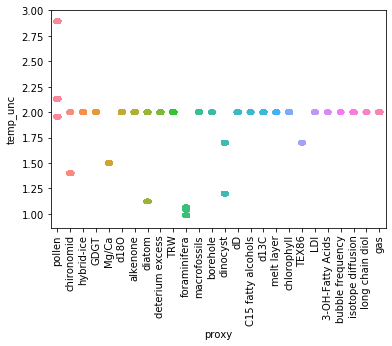

In [91]:
import seaborn as sns
ax = sns.stripplot('proxy', 'temp_unc', data=df)
for t in ax.get_xticklabels():
    t.set_rotation(90)

In [101]:
np.sum(~df.age.between(-70, 14000).values)

78587

In [ ]:
df.loc[~df.temperature.between(-200, 200).values, 'temperature'] = np.nan

In [65]:
df.loc[~df.age.between(-70, 14000).values, 'age'] = np.nan

In [66]:
for col in ['seasonality', 'datum', 'temperature', 'age', 'modern']:
    print(f'{col}: {df[col].isnull().sum()}')

seasonality: 341
datum: 19772
temperature: 20501
age: 78587
modern: 910


In [31]:
print(df.shape)
df.dropna(subset=['seasonality', 'datum', 'temperature', 'age', 'modern'], inplace=True)
print(df.shape)

(236555, 33)
(134559, 33)


In [49]:
df.TSid.unique().size

1201

In [32]:
area = output_ds['cell_area']
output_ds['time'] = time = xr.Variable(
    ('time', ), np.arange(50, 12001, 200),
    attrs = {'long_name': 'Age', 'units': 'years since 1950-01-01'})
output_ds['temperature'] = xr.Variable(
    ('time', area.dims[0]), np.full((time.size, area.size), np.nan),
    encoding = dict(coordinates='clat clon'))

ensembles = {
    key: ge.GAMEnsemble(
        group.set_index('age'), target=output_ds.psy['temperature'],
        climate='temperature', ds_id='TSid')
    for key, group in df.groupby('seas')
}

In [33]:
class SilentProgressBar(pygam.pygam.ProgressBar):
    def __call__(self, x):
        return x
    
pygam.pygam.ProgressBar = SilentProgressBar

In [34]:
%%time
for ensemble in pg.utils.log_progress(ensembles.values()):
    ds = ensemble.input_data
    ages = ensemble.sample_ages(size=1000, use_dask=False)
    ds['age_ensemble'] = ages.load()
    ds['temperature_ensemble'] = ages.rename('temperature_ensemble').copy(
        data=np.random.normal(ds.temperature, ds.temp_unc,
                              size=ages.shape))

Starting at 2019-11-12 02:03:44.022274
|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 0.746 minutes
Finished at 2019-11-12 02:05:59.745908. Time needed: 2.262 minutes
CPU times: user 2min 14s, sys: 1.33 s, total: 2min 15s
Wall time: 2min 15s


In [42]:
output_ds['time']

<xarray.DataArray 'time' (time: 49)>
array([    0,   250,   500,   750,  1000,  1250,  1500,  1750,  2000,  2250,
        2500,  2750,  3000,  3250,  3500,  3750,  4000,  4250,  4500,  4750,
        5000,  5250,  5500,  5750,  6000,  6250,  6500,  6750,  7000,  7250,
        7500,  7750,  8000,  8250,  8500,  8750,  9000,  9250,  9500,  9750,
       10000, 10250, 10500, 10750, 11000, 11250, 11500, 11750, 12000])
Coordinates:
  * time     (time) int64 0 250 500 750 1000 ... 11000 11250 11500 11750 12000
Attributes:
    long_name:  Age
    units:      years since 1950-01-01

In [39]:
outputs = {}
with Client(n_workers=4, dashboard_address=':33425', memory_limit='16GB') as client:
    for key, ensemble in ensembles.items():
        if key != 'jja':
            continue
        print(f"Predicting {key}")

        outputs[key] = ensemble.predict(
            quantiles=np.unique(np.r_[[0.01, 0.025, 0.33, 0.66, 0.975, 0.99], np.arange(0.05, 1, 0.05)]), 
            size=1000, client=client)
        outputs[key]['time'].values *= -1
        outputs[key].to_netcdf(f'../data/{key}.nc')

Predicting jja
Starting at 2019-11-12 02:22:49.863123


/Users/psommer/miniconda/envs/temperature12k/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2881: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


/Users/psommer/miniconda/envs/temperature12k/lib/python3.7/site-packages/ipykernel/zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 1.090 minutesss
Finished at 2019-11-12 05:41:15.745043. Time needed: 198.431 minutes
